In [1]:
import torch
from training.summary.datamodule import SummaryDataset
from transformers import ViTImageProcessor
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import numpy as np
from moviepy.editor import VideoFileClip, concatenate_videoclips
from pydub import AudioSegment
from pydub.silence import detect_nonsilent

from v2021 import SummaryModel

In [21]:
preprocessor = ViTImageProcessor.from_pretrained(
    "google/vit-base-patch16-224", size=224, device='cuda'
)

# 오디오 분석을 위한 설정
def extract_audio_segments(video_path, nonsilent_threshold=-50, min_silence_len=500):
    video_clip = VideoFileClip(video_path)
    audio_path = "temp_audio.wav"
    video_clip.audio.write_audiofile(audio_path, codec='pcm_s16le')
    sound = AudioSegment.from_file(audio_path)
    nonsilent_parts = detect_nonsilent(
        sound,
        min_silence_len=min_silence_len,
        silence_thresh=nonsilent_threshold
    )
    return nonsilent_parts

In [22]:
SAMPLE_EVERY_SEC = 2

video_path = 'videos/news2.mp4'

cap = cv2.VideoCapture(video_path)

n_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
fps = cap.get(cv2.CAP_PROP_FPS)

video_len = n_frames / fps

print(f'Video length {video_len:.2f} seconds!')

frames = []
last_collected = -1

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    timestamp = cap.get(cv2.CAP_PROP_POS_MSEC) 
    second = timestamp // 1000

    if second % SAMPLE_EVERY_SEC == 0 and second != last_collected:
        last_collected = second
        frames.append(frame)

features = preprocessor(images=frames, return_tensors="pt")["pixel_values"]

print(features.shape)

Video length 599.97 seconds!
torch.Size([300, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


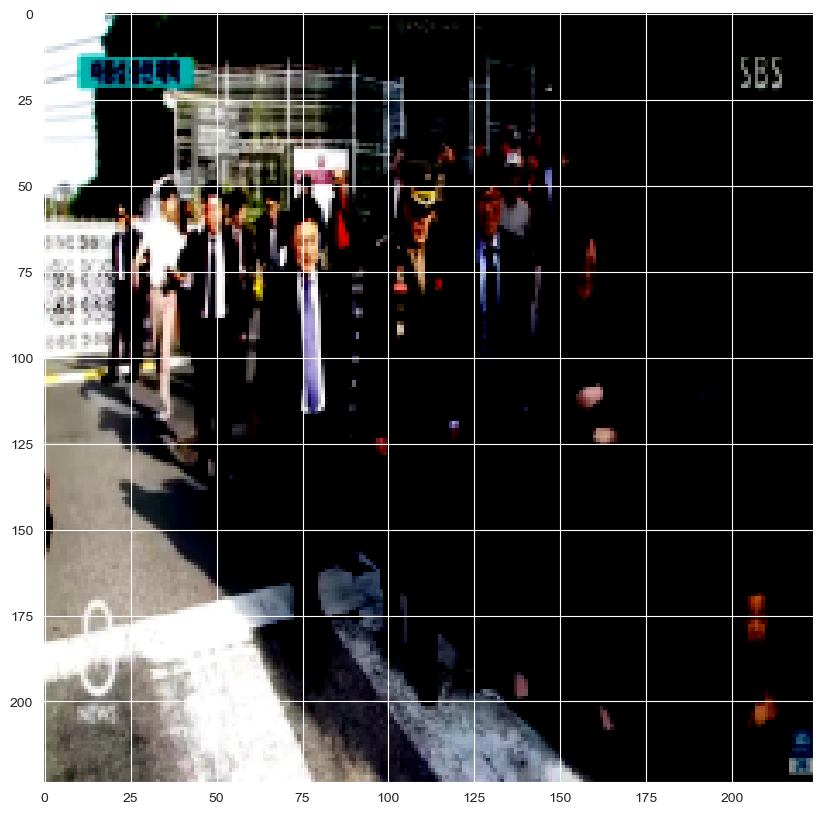

In [23]:
plt.figure(figsize=(10, 10))
plt.imshow(features[0].numpy().transpose(1, 2, 0)[:, :, ::-1])

In [24]:
model = SummaryModel.load_from_checkpoint('summary.ckpt')
model.to('cpu')
model.eval()


Lightning automatically upgraded your loaded checkpoint from v1.4.9 to v2.2.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\jwoo3\OneDrive\바탕 화면\video-summarization-master\video-summarization-master\summary.ckpt`


SummaryModel(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_featu

100%|██████████| 300/300 [01:17<00:00,  3.89it/s]


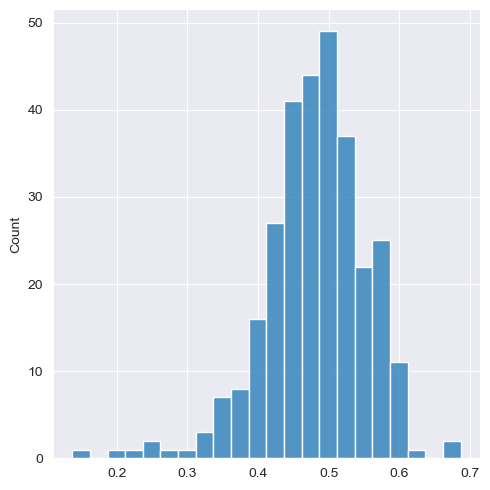

In [25]:
features = features.to('cpu')

y_pred = []

for frame in tqdm(features):
    y_p = model(frame.unsqueeze(0))
    y_p = torch.sigmoid(y_p)

    y_pred.append(y_p.cpu().detach().numpy().squeeze())

y_pred = np.array(y_pred)

sns.displot(y_pred)

In [26]:
THRESHOLD = 0.2

total_secs = 0
max_duration = 120  # 요약 비디오 최대 길이 (초)

clip = VideoFileClip(video_path)
n_frames = len(y_pred)  # y_pred는 모델이 예측한 각 프레임의 중요도
sorted_indices = np.argsort(-y_pred)  # 중요도에 따라 내림차순 정렬

selected_clips = []
total_duration = 0

# 중요도 순으로 클립 선택 및 시간 순 정렬
for idx in sorted_indices:
    sec = idx * SAMPLE_EVERY_SEC
    end_sec = sec + SAMPLE_EVERY_SEC
    if total_duration + SAMPLE_EVERY_SEC <= max_duration:
        selected_clips.append((sec, end_sec))
        total_duration += SAMPLE_EVERY_SEC
    else:
        break

# 클립을 시간 순으로 정렬
selected_clips.sort()

In [27]:
# 클립을 비디오로 합치기
subclips = [clip.subclip(start, end) for start, end in selected_clips]
# 기존의 요약 비디오 생성
if subclips:
    summarized_clip = concatenate_videoclips(subclips, method="compose")
    temp_output_path = "videos/news2_result.mp4"
    summarized_clip.write_videofile(temp_output_path, codec='libx264', audio_codec='aac')

    # 오디오 세그먼트 기반 클립 조정
    nonsilent_parts = extract_audio_segments(temp_output_path)  # 요약된 비디오에서 오디오 분석
    adjusted_clips = []
    clip_bounds = []

    for start_i, end_i in nonsilent_parts:
        start_sec = max(0, start_i / 1000.0 - 0.1)  # 시작 전 0.1초 여유
        end_sec = min(end_i / 1000.0 + 0.1, summarized_clip.duration)  # 끝 후 0.1초 여유

        # 클립 시작과 끝에 여분의 시간을 추가하지만 다른 클립과 겹치지 않도록 조정
        # 새 클립의 시작 시간은 이전 클립의 끝 시간보다 늦어야 함
        if clip_bounds:
            last_end_sec = clip_bounds[-1][1]
            start_sec = max(start_sec, last_end_sec + 0.5)  # 이전 클립의 끝나는 시간 + 0.5초 이후로 시작

        # 비디오 길이를 초과하지 않도록 조정
        start_sec = min(start_sec, summarized_clip.duration)
        end_sec = min(end_sec, summarized_clip.duration)

        if start_sec < end_sec:  # 시작 시간이 끝 시간보다 늦지 않은 경우에만 클립 추가
            subclip = summarized_clip.subclip(start_sec, end_sec)
            adjusted_clips.append(subclip)
            clip_bounds.append((start_sec, end_sec))

    # 조정된 클립 재결합
    if adjusted_clips:
        final_clip = concatenate_videoclips(adjusted_clips, method="compose")
        final_output = "videos/news2_final_result.mp4"
        final_clip.write_videofile(final_output, codec='libx264', audio_codec='aac')
        final_clip.ipython_display(width=640, maxduration=240)
    else:
        print("No suitable clips found based on audio analysis.")
else:
    print("No clips meet the threshold criteria or max duration limit.")


Moviepy - Building video videos/news2_result.mp4.
MoviePy - Writing audio in news2_resultTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video videos/news2_result.mp4


Moviepy - Done !
Moviepy - video ready videos/news2_result.mp4
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.
Moviepy - Building video videos/news2_final_result.mp4.
MoviePy - Writing audio in news2_final_resultTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video videos/news2_final_result.mp4


Moviepy - Done !
Moviepy - video ready videos/news2_final_result.mp4
Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in __temp__TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video __temp__.mp4


Moviepy - Done !
Moviepy - video ready __temp__.mp4
